### np.pad

在卷积神经网络中为了因卷积导致的避免边缘信息的丢失，我们通常给图像边缘填充0

np.pad(array, pad_width, mode, \*\*kwargs)  
pad_width: ((before_1, after_1),(before_2,after_2),...(before_N,after_N)) 对每一维 axis 在前面填充 before 个，在后面填充 after 个。比如对二维数组，((2,2),(1,1)) 指的是在第 0 维也就是列上下各填充2，左右各填充1。它也可以是 (pad,) 或直接是一个数值的形式, 表示的就是 before=after=pad  
mode:填充的模式  
* 'constant'
* 'maximum'
* 'minimum'
* 'median'


In [2]:
import numpy as np

下面四个是等价的

In [3]:
arr1 = np.array([1,2,3,4,5])
np.pad(arr1, 2, 'constant')

array([0, 0, 1, 2, 3, 4, 5, 0, 0])

In [4]:
np.pad(arr1, (2,), 'constant')

array([0, 0, 1, 2, 3, 4, 5, 0, 0])

In [5]:
np.pad(arr1, (2,2), 'constant')

array([0, 0, 1, 2, 3, 4, 5, 0, 0])

In [6]:
np.pad(arr1, ((2,2)), 'constant')

array([0, 0, 1, 2, 3, 4, 5, 0, 0])

In [16]:
arr2 = np.arange(1,17).reshape(4,4)
arr2

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

In [17]:
np.pad(arr2, ((1,1),(2,2)), 'constant')

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  2,  3,  4,  0,  0],
       [ 0,  0,  5,  6,  7,  8,  0,  0],
       [ 0,  0,  9, 10, 11, 12,  0,  0],
       [ 0,  0, 13, 14, 15, 16,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

### 数字图像处理中的卷积操作

In [19]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input. 
        

    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
    N, C, H, W = np.shape(x)
    F = np.shape(w)[0]
    HH, WW = np.shape(w)[2:]
    pad = conv_param['pad']
    stride = conv_param['stride']
    x_pad = np.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad)), 'constant')
    H_hat = int((H + 2*pad - HH) / stride + 1)      # 注意前面加一定要 int
    W_hat = int((W + 2*pad - HH) / stride + 1)
    out = np.zeros((N, F, H_hat, W_hat))
    for i in range(N):
        for j in range(F):
            b_in = b[j]
            x_in = x_pad[i]
            w_in = w[j]
            for m in range(H_hat):
                for n in range(W_hat):
                    x_ = x_in[:, m*stride:m*stride+HH, n*stride:n*stride+WW]
                    x_ = x_.reshape(1,-1)
                    w_ = w_in.reshape(1,-1)
                    out[i,j,m,n] = np.sum(x_ * w_) + b_in
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b, conv_param)
    return out, cache

In [82]:
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [83]:
kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')

/Users/lovelyfrog/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


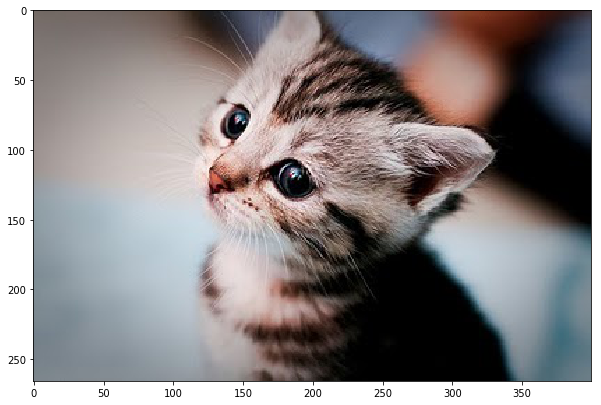

In [84]:
plt.imshow(kitten)

In [85]:
kitten.shape

(266, 400, 3)

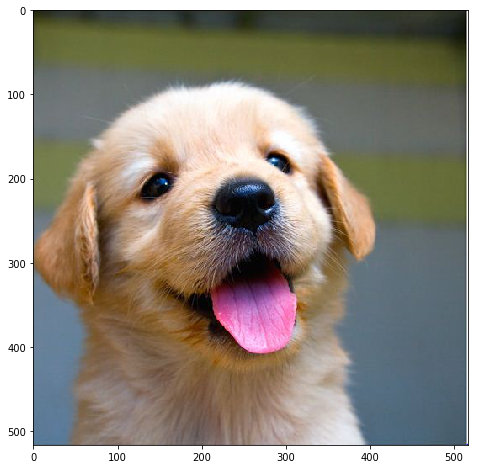

In [86]:
plt.imshow(puppy)

In [87]:
puppy.shape

(517, 517, 3)

In [88]:
# 先将 kitten 裁剪长宽相同的图像
d = kitten.shape[1] - kitten.shape[0]
kitten_crop = kitten[:,d//2:-d//2,:]

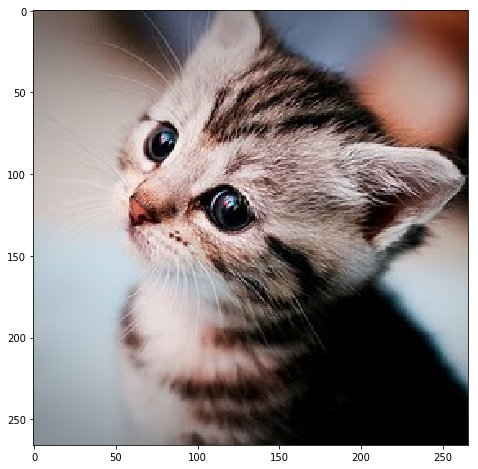

In [89]:
plt.imshow(kitten_crop)

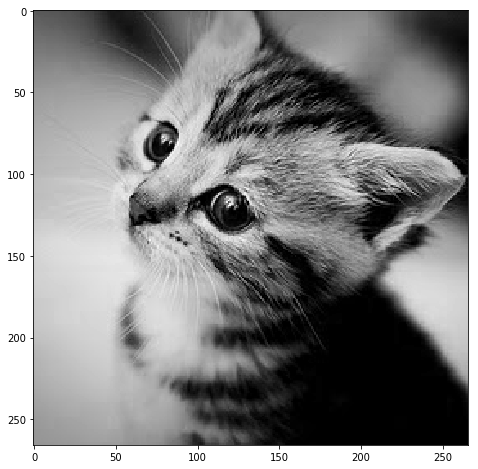

In [90]:
plt.imshow(kitten_crop[:,:,2])

In [91]:
## 将 kitten_prop 和 puppy 缩小整合到输入 x 中
img_size = 200
x = np.zeros((2, 3, 200, 200))
#图像读入是 HxWxC 维数据，为了我们训练方便将其转换为 CxHxW 
x[0,:,:,:] = imresize(kitten_crop,(img_size,img_size)).transpose(2,0,1)
x[1,:,:,:] = imresize(puppy, (img_size,img_size)).transpose(2,0,1)

/Users/lovelyfrog/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.
/Users/lovelyfrog/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [92]:
# 两个filter ,一个灰度，一个是边缘化
w = np.zeros((2,3,3,3))
# red-channel, green-channel, blue-channel
w[0,0,:,:] = np.array([[0, 0, 0],
                       [0, 0.3, 0],
                       [0, 0, 0]])
w[0,1,:,:] = np.array([[0, 0, 0],
                       [0, 0.6, 0],
                       [0, 0, 0]])
w[0,2,:,:] = np.array([[0, 0, 0],
                       [0, 0.1, 0],
                       [0, 0, 0]])

In [93]:
# 第二个 filter 识别blue-channel 的边缘信息
w[1,2,:,:] = np.array([[1, 0, -1],
                       [2, 0, -2],
                       [1, 0, -1]])

In [94]:
# 偏置项b,对于第一个filter没必要加偏置，对于第二个加一个128的偏置防止出现负数
b = np.array([0, 128])

In [95]:
# 卷积，输出为2个 2channel 
out, _ = conv_forward_naive(x, w, b, {'stride':1,'pad':1})

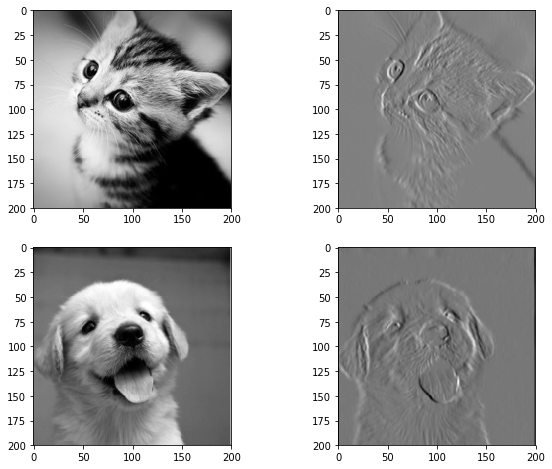

In [97]:
plt.subplot(2,2,1)
plt.imshow(out[0,0])
plt.subplot(2,2,2)
plt.imshow(out[0,1])
plt.subplot(2,2,3)
plt.imshow(out[1,0])
plt.subplot(2,2,4)
plt.imshow(out[1,1])

In [98]:
# normalize image(将最大的像素值设置为255，其他的按照倍数加倍)
def norm_image(img):
    img_max, img_min = np.max(img), np.min(img)
    img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))

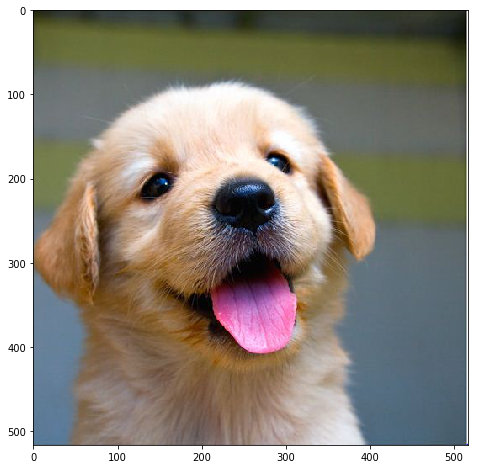

In [99]:
norm_image(puppy)

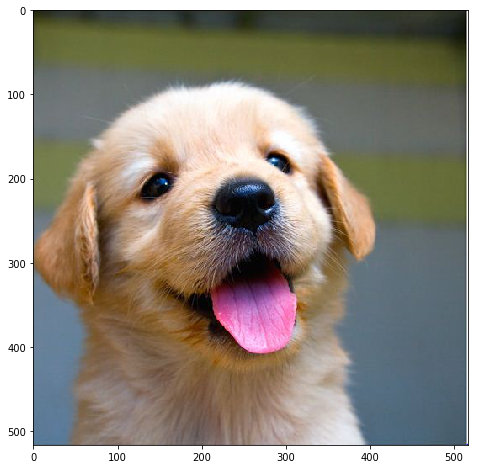

In [100]:
plt.imshow(puppy)

In [101]:
# 构建几个不同的识别blue-channel 的边缘的filter
w1 = np.zeros((1,3,3,3))
w2 = np.zeros((1,3,3,3))
w3 = np.zeros((1,3,3,3))
w1[0,2,:,:] = np.array([[1, 0, -1],
                       [2, 0, -2],
                       [1, 0, -1]])
w2[0,2,:,:] = np.array([[1, 0, -1],
                       [2, 0, -2],
                       [1, 0, -1]]).T
w3[0,2,:,:] = np.array([[1, 0, -1],
                       [1, 0, -1],
                       [1, 0, -1]])

In [102]:
x_puppy = np.zeros((1,3,img_size,img_size))
x_puppy[0,:,:,:] = imresize(puppy, (img_size,img_size)).transpose(2,0,1)

/Users/lovelyfrog/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [104]:
out1, _ = conv_forward_naive(x_puppy, w1, [128], {'stride':1,'pad':1})
out2, _ = conv_forward_naive(x_puppy, w2, [128], {'stride':1,'pad':1})
out3, _ = conv_forward_naive(x_puppy, w3, [128], {'stride':1,'pad':1})

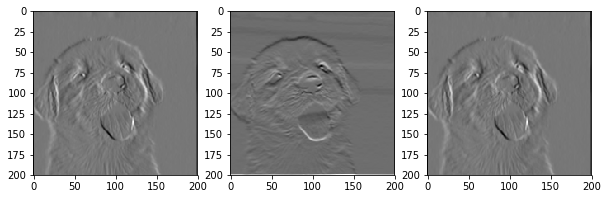

In [106]:
plt.subplot(1,3,1)
plt.imshow(out1[0,0])
plt.subplot(1,3,2)
plt.imshow(out2[0,0])
plt.subplot(1,3,3)
plt.imshow(out3[0,0])

In [109]:
a = np.array([1,2,3,4])
a >= 4

array([False, False, False,  True])

In [112]:
kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')

/Users/lovelyfrog/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [113]:
kitten.shape

(266, 400, 3)

In [114]:
np.random.randn(2,3,3)

array([[[ 0.30618404, -0.03928915, -0.6751011 ],
        [ 1.03069189, -0.43551721,  1.38756323],
        [-0.07300322,  0.69408593, -0.60449662]],

       [[-1.78665448, -0.00782821, -0.74137697],
        [ 0.1164158 ,  1.24033905,  1.34622646],
        [-0.14356045,  0.40324835,  0.13145143]]])

In [115]:
32*16*16

8192